## VEHICLE DETECTION AND COUNTING USING YOLO ARCHITECTURE
**VISION AND COGNITIVE SYSTEMS FINAL PROJECT**

Authors:
- David Altamirano (2081255)
- Stefano Meza (2070772)

The main purpose of the presented project is to perform detecting counting vehicles and counting it based on a specific method. We are going to present different approaches classified in: 
- Building blocks: we show the main function that we are going to use for detecting objects in images and videos.
- Methodology: the learning procedure applied along the project has been explored. Firtly, we create our dataset with 8 different classes for training Yolo v8 architecture. Second, a dataset based on 4 classes was used in order to obtain a bigger dataset and improve the results. Third, the Yolo pretrained model with COCO dataset was used for detecting vehicles. Finally, vehicles was counted both in unidirectional and bidirectional ways.
- Results: after a comparison between the different approaches, the best model was used to count vehicles in different videos.

### Section 0: Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from distutils.dir_util import copy_tree
from IPython.display import clear_output
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import patches
import math

**Check GPU**

In [2]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

torch.cuda.empty_cache()

Is CUDA supported by this system? True
CUDA version: 12.1


### Section 1: Building Blocks

In this section we have defined the following functions:
- Tracker(): retrieves the id of the detected objects used later in the next stages for avoiding double-counting. 

In [2]:
class Tracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h, ci = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 35:
                    self.center_points[id] = (cx, cy)
#                    print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id, ci])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count, ci])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id, ci = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids


- images_plotter(): given a training the images are plotted with their respective bounding box and label

In [3]:
def images_plotter(location, samples, labels, set):
    images_samples = (os.listdir(os.path.join(location, set, "images")))
    np.random.shuffle(images_samples)
    images_samples = images_samples[:samples]
    #labels_samples = sorted(os.listdir(os.path.join(location, "train", "labels")))[:samples]

    images_sam = []
    labels_sam = []
    bbox = []
    rows = int(np.sqrt(samples))

    for img in images_samples:
        images_sam.append(os.path.join(location, set, "images", img))
        labels_sam.append(os.path.join(location, set, "labels", os.path.splitext(img)[0] + ".txt"))

    for i in labels_sam:
        bbox.append(np.loadtxt(i))
            

    fig, axis = plt.subplots(rows, rows, figsize=(10,10))
    axis = axis.flatten()

    for idx, img in enumerate(images_sam):
        axis[idx].imshow(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)), axis[idx].axis("off")
        a = []
        for j in bbox[idx]:
    
            H, L, _ = cv2.imread(img).shape
            if type(j) == np.ndarray:
                axis[idx].add_patch(patches.Rectangle((int(j[1]*L-j[3]*L/2), int(j[2]*H-j[4]*H/2)), int(j[3]*L), int(j[4]*H), angle=0, fill=False, edgecolor="red", lw=2))
                axis[idx].annotate("{}".format(labels[int(j[0])]), (int(j[1]*L-j[3]*L/2), int(j[2]*H-j[4]*H/2)), color="cyan")
            
            else:
                a.append(j)
                if len(a) == 5:
                    axis[idx].add_patch(patches.Rectangle((int(a[1]*L-a[3]*L/2), int(a[2]*H-a[4]*H/2)), int(a[3]*L), int(a[4]*H), angle=0, fill=False, edgecolor="red", lw=2))
                    axis[idx].annotate("{}".format(labels[int(a[0])]), (int(a[1]*L-a[3]*L/2), int(a[2]*H-a[4]*H/2)), color="cyan")

- video_tagging_unidirectional: given a video and a model, we draw a line for counting the vehicles that pass through it distinguishing between cars, autobuses, motorcycles and trucks.

In [4]:
def video_taggging_unidirectional(video_name, model, classes, keys, video_out_name,  threshold = 0.5, v_path = "./videos"):

    """
        video_tagging: Given a video and a pretrained model, perform the following steps:
                        

        Parameters:     video_name <- video's name to be tagged
                        model <- pretrained YOLO model
                        video_path <- location of input video

    """

    # Define parameters
    n_index = []         # Car list
    nt_v = [0]*len(classes)
    c_index = []         # Class index
    keys = keys        # COCO's labels
    model = YOLO(model)  # Load a custom model
    eps = 15              # Minimum distance for counting car
    tracker = Tracker()  # Tracking function


    # Video parameters
    video_path = os.path.join(v_path, video_name)  # Input video file          
    video_path_out = os.path.splitext(video_path)[0] +"_" + video_out_name +".mp4"

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    print(video_path_out)
    out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'),
                           int(cap.get(cv2.CAP_PROP_FPS)), (W, H))
    
    x_l = (0,int(H/2)+10)   # Line position (Start point)
    y_l = (W, int(H/2)+10)  # Line position (End point)

    while ret:

        results = model(frame, verbose = False)[0]
        track_list = []

        cv2.line(frame, x_l, y_l, (0, 255, 255),  3) 
        cv2.putText(frame, ("Total vehicles: {}".format(len(n_index))), (5, int(H/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,0), 2, cv2.LINE_AA)
        displacement = 20 


        for ix, vx in enumerate(classes):

            cv2.putText(frame, ("Num. {}: {}".format(vx, nt_v[ix])), (5, int(H/10)+ displacement), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2, cv2.LINE_AA)
            displacement += 20

        for result in results.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = result
            if score > threshold:
                track_list.append([x1,y1,x2,y2, class_id])

        bbox_id = tracker.update(track_list)

        for bbox in bbox_id:
            x3, y3, x4, y4, id, ci = bbox
            c1 = int(x3+(x4-x3)/2)
            c2 = int(y4+(y3-y4)/2)
        
            if H/2 - abs(c2 - H) < eps and H/2 - abs(c2 - H) > 0 :

                if n_index.count(id) == 0:
                    n_index.append(id)
                    for iy, vy in enumerate(keys):
                        if ci == vy:
                            nt_v[iy] += 1
                            cv2.putText(frame, str(nt_v[iy]), (c1, c2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)

                cv2.circle(frame, (c1, c2), 5, (0,0,255), -1)
        
                
        out.write(frame)
        ret, frame = cap.read()

    cap.release()
    out.release()

    return(nt_v)

- video_tagging_bidirectional: given a video and a model, we draw a line for counting the vehicles that pass through it distinguishing between cars, autobuses, motorcycles and trucks. Now, considering the direction of the vehicles.

In [23]:
def video_taggging_bidirectional(video_name, model,classes,keys,video_out_name, threshold = 0.5, v_path = "./videos"):

    """
        video_tagging_bidirectional: Given a video, a pretrained model and set of labels (objects to be detected) perform the following:
                                    1) Create lists for storing the number of vehicles (take into account the direction)
                                    2) Create one counter for each class, classes are defined in the input "classes"
                                    3) Using pretrained model, detect objects perframe with its bounding boxes
                                    4) Compute the center of each one
                                    5) If objects are inside a certain value (eps), count it (distinguish direction)
                                    6) Print results in video and export it


        Parameters:     video_name <- video's name to be used
                        model <- pretrained YOLO model
                        video_path <- location of input video
                        classes <- set of labels to be detected

    """

    # Define parameters
    n_index = []                             # Detected object's ID
    n_t = [[],[]]                            # List for storing ID's depending on direction
    ni_v = [[0]*len(classes),[0]*len(classes)]             # List of incoming and outcoming vehicles (distinguish class)
    direction = ["incoming", "outcoming"]
    jump = 0
    keys = keys                         # COCO's labels

    c_index = []         # Class index
    model = YOLO(model)  # Load a custom model
    eps = 4              # Minimum distance for counting car
    tracker = Tracker()  # Tracking function


    # Video parameters
    video_path = os.path.join(v_path, video_name)  # Input video file          
    video_path_out = os.path.splitext(video_path)[0] +"_" + video_out_name +".mp4"
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'),
                           int(cap.get(cv2.CAP_PROP_FPS)), (W, H))
    
    x_l = (0,int(H/2))   # Line position (Start point)
    y_l = (W, int(H/2))  # Line position (End point)


    while ret:
        # Detect objects in given frame
        results = model(frame, verbose = False)[0]
        track_list = []

        cv2.line(frame, x_l, y_l, (0, 255, 255),  3) 

        # Print results on video
        for ix, vx in enumerate(direction):
            displacement = 20
            cv2.putText(frame, ("Total vehicles {}: {}".format(vx, len(n_t[ix]))), (5, int(H/10)+ jump), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,0), 2, cv2.LINE_AA)
            for iy, vy in enumerate(classes):
                cv2.putText(frame, ("Num. {}: {}".format(vy, ni_v[ix][iy])), (5, int(H/10)+ displacement + jump), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2, cv2.LINE_AA)
                displacement += 20
            jump = 150
        
        jump = 0


        # Extract bounding boxes of objects
        for result in results.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = result

            if score > threshold:
                track_list.append([x1,y1,x2,y2, class_id])
        
        # Track ID's 
        bbox_id = tracker.update(track_list)

        for bbox in bbox_id:
            x3, y3, x4, y4, id, ci = bbox
            
        # Compute center of object
            c1 = int(x3+(x4-x3)/2)
            c2 = int(y4+(y3-y4)/2)

            # Vehicles In
            if H/2 - abs(c2 - H) < eps and H/2 - abs(c2 - H) > 0 :

                if n_index.count(id) == 0:
                    n_index.append(id)
                    n_t[0].append(id)

                    for iz, vz in enumerate(keys):
                        if ci == vz:
                            ni_v[0][iz] += 1
                            cv2.putText(frame, str(ni_v[0][iz]), (c1, c2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
            
            # Vehicles Out
            if H/2 - abs(c2 - H) > -eps and H/2 - abs(c2 - H) < 0:
            
                if n_index.count(id) == 0:
                        n_index.append(id)
                        n_t[1].append(id)
                        for iz, vz in enumerate(keys):
                            if ci == vz:
                                ni_v[1][iz] += 1
                                cv2.putText(frame, str(ni_v[1][iz]), (c1, c2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)

            cv2.circle(frame, (c1, c2), 5, (0,0,255), -1)
        
                
        out.write(frame)
        ret, frame = cap.read()

    cap.release()
    out.release()

    return(ni_v)

In [6]:
def show_results_uni(values, labels):
    print("Unidirectional test", "\n")
    print("Total number of vehicles detected: {}".format(sum(values)), "\n")
    for i in range(len(labels)):
        print("Number of {}: {}".format(labels[i], values[i]))
    
    return


def show_results_bi(values, labels):
    print("Bidirectional test", "\n")
    name = ["incoming", "outcoming"]
    for i in range(2):
        print("Total number of vehicles {} detected: {}".format(name[i], sum(values[i])), "\n")
        for j in range(len(labels)):
            print("Number of {}: {}".format(labels[j], values[i][j]))
        print("\n")
    
    return

- model_tester_image: given the model and the images, detect the objects and plot with the bounding boxes 

In [7]:
def model_tester_image(model, images, labels):
    model = YOLO(model)
    results = model(images)
    box = []
    probs =  []
    for result in results:
        box.append(np.array(result.boxes.xywh.cpu()))
        probs.append(np.array(result.boxes.cls.cpu()))

    fig, axis = plt.subplots(1, 3, figsize = (15,5))

    for i, val in enumerate(images):
        axis[i].imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB)), axis[i].axis("off")
        axis[i].set_title("Num. vehicles: {}".format(len(box[i])))
        for j in range (0,len(box[i])):
            axis[i].add_patch(patches.Rectangle(((box[i][j][0] - box[i][j][2]/2) ,(box[i][j][1] - box[i][j][3]/2) ), box[i][j][2], box[i][j][3], fill=False, edgecolor="red", lw=2))
            axis[i].annotate("{}".format(labels[int(probs[i][j])]), ((box[i][j][0] - box[i][j][2]/2) ,(box[i][j][1] - box[i][j][3]/2) ), color="cyan")


- plot_train: plot the results of the training. Because computational troubles, the training was done every 30 epochs, doing the new train with the previous output. The train was done 7 times. 

In [8]:
def plot_train(csv_file):
    fig, axis = plt.subplots(2, 3, figsize = (14,8))

    df = pd.read_csv(csv_file)
    
    epochs = [30,60,90,120,150,180,210,240,270]

    axis[0,0].plot(df['         train/box_loss'], color="black")
    axis[0,0].set_title("train/box_loss")
    axis[0,0].grid()
    for e in epochs:
        axis[0,0].axvline(e, color="red", ls="dashed", lw=0.7)

    axis[0,1].plot(df['         train/cls_loss'], color="black")
    axis[0,1].set_title("train/cls_loss")
    axis[0,1].grid()
    for e in epochs:
        axis[0,1].axvline(e, color="red", ls="dashed", lw=0.7)

    axis[0,2].plot(df['         train/dfl_loss'], color="black")
    axis[0,2].set_title("train/dfl_loss")
    axis[0,2].grid()
    for e in epochs:
        axis[0,2].axvline(e, color="red", ls="dashed", lw=0.7)

    axis[1,0].plot(df['   metrics/precision(B)'], color="black")
    axis[1,0].set_title("metrics/precision(B)")
    axis[1,0].set_xlabel("Epochs")
    axis[1,0].grid()
    for e in epochs:
        axis[1,0].axvline(e, color="red", ls="dashed", lw=0.7)

    axis[1,1].plot(df['      metrics/recall(B)'], color="black")
    axis[1,1].set_title("metrics/recall(B)")
    axis[1,1].set_xlabel("Epochs")
    axis[1,1].grid()
    for e in epochs:
        axis[1,1].axvline(e, color="red", ls="dashed", lw=0.7)

    axis[1,2].plot(df['       metrics/mAP50(B)'], color="black")
    axis[1,2].set_title("metrics/mAP50(B)")
    axis[1,2].set_xlabel("Epochs")
    axis[1,2].grid()
    for e in epochs:
        axis[1,2].axvline(e, color="red", ls="dashed", lw=0.7)
    
    plt.show()

### Section 2: Methodology

#### Approach A

For this approach, the following pipeline has been stablished:

1. First, create a dataset based on 8 different labels which are: 
    - car, SUV, pick up, big truck, truck, bus, motorcycle, van.
    
    Boundings were done from scratch. Additionally, augmentation steps were performed for increasing sample size (done with Roboflow)

2. Then, we split into training, validation and test set applying the following rates:
    - training (70%), validation(20%), test(10%)

3. After that, model was trained using **yolov8n.yaml** for 300 epochs. Due to some computational disadvantages, training was splitted and reruned with previous output. 

4. Next, using previously trained model, vehicle counting was done in images.

5. Finally, the model was applied in videos counting the number of vehicles (distinguishing classes) and taking into account the direction (incoming and outcoming) 
    

**A1. Images**

/tmp/ipykernel_12204/949212664.py:17: UserWarning: loadtxt: input contained no data: "./approachA/train/labels/yt-mu0pAQHlHYE-0010_jpg.rf.8425d37aa8274d85d148586c63368f0c.txt"
  bbox.append(np.loadtxt(i))
/tmp/ipykernel_12204/949212664.py:17: UserWarning: loadtxt: input contained no data: "./approachA/train/labels/yt-Ww9ENGtleFI-0086_jpg.rf.1e4bf85d784bbbcc6546fc5f88404e34.txt"
  bbox.append(np.loadtxt(i))


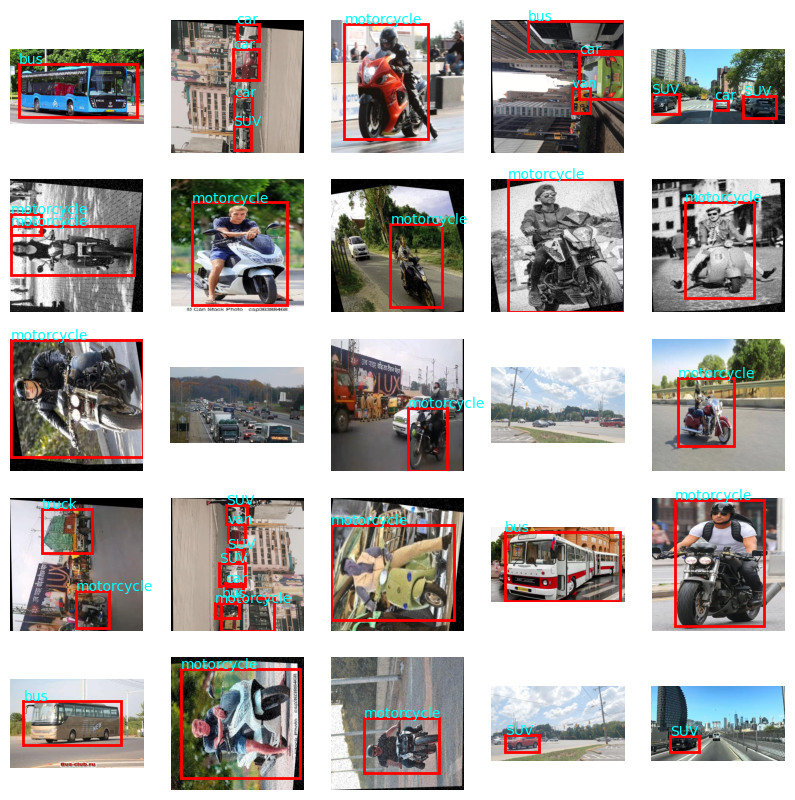

In [16]:
# Define labels for approachA
labels_A = ['SUV', 'big truck', 'bus', 'car', 'motorcycle', 'pickup', 'truck', 'van']
keys_A = [0,1,2,3,4,5,6,7]
# Define path for folder with images and labels
A1_path = "./approachA"


# Display training set images and labels
n_samples = 25
images_plotter(A1_path, n_samples, labels_A, "train")           

**A2. Training**

In [12]:
# Run model A using nano version of yolov8
model_A = YOLO("yolov8n.yaml")
#results_A = model_A.train(data = "approachA.yaml", epochs = 300, patience= 300, name ="approachA")
best_A = "./runs/detect/approachA/weights/best.pt"

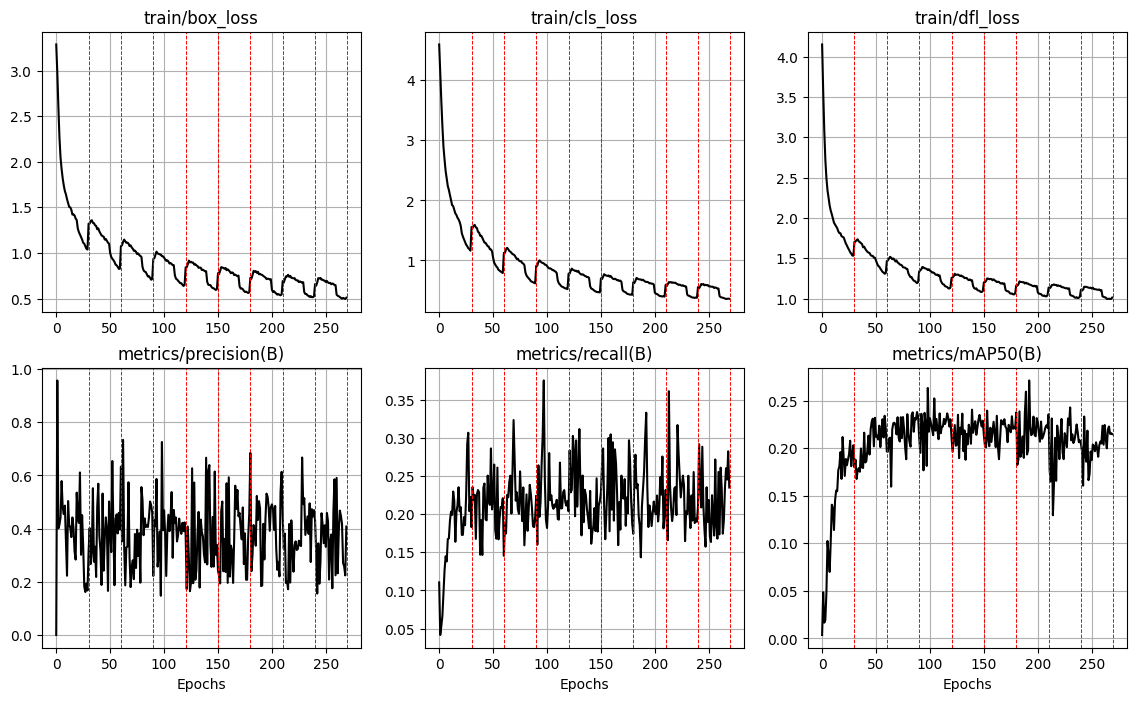

In [13]:
plot_train("./runs/detect/approachA/approachA.csv")

(<matplotlib.image.AxesImage at 0x7fcb78134430>, (-0.5, 2999.5, 2249.5, -0.5))

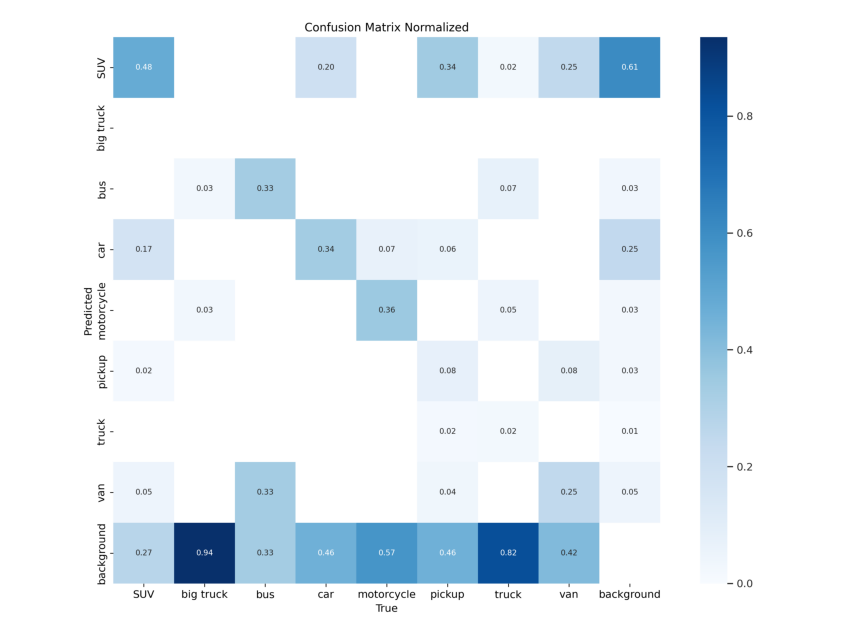

In [62]:
# Confusion matrix normalized after training for 7 times

confusion_nomr = cv2.imread("./runs/detect/approachA/confusion_matrix_normalized.png")
plt.figure(figsize=(11, 8))
plt.imshow(cv2.cvtColor(confusion_nomr, cv2.COLOR_BGR2RGB)), plt.axis("off")

(<Axes: title={'center': 'Ex2. Validation'}>,
 Text(0.5, 1.0, 'Ex2. Validation'),
 (-0.5, 1919.5, 1099.5, -0.5))

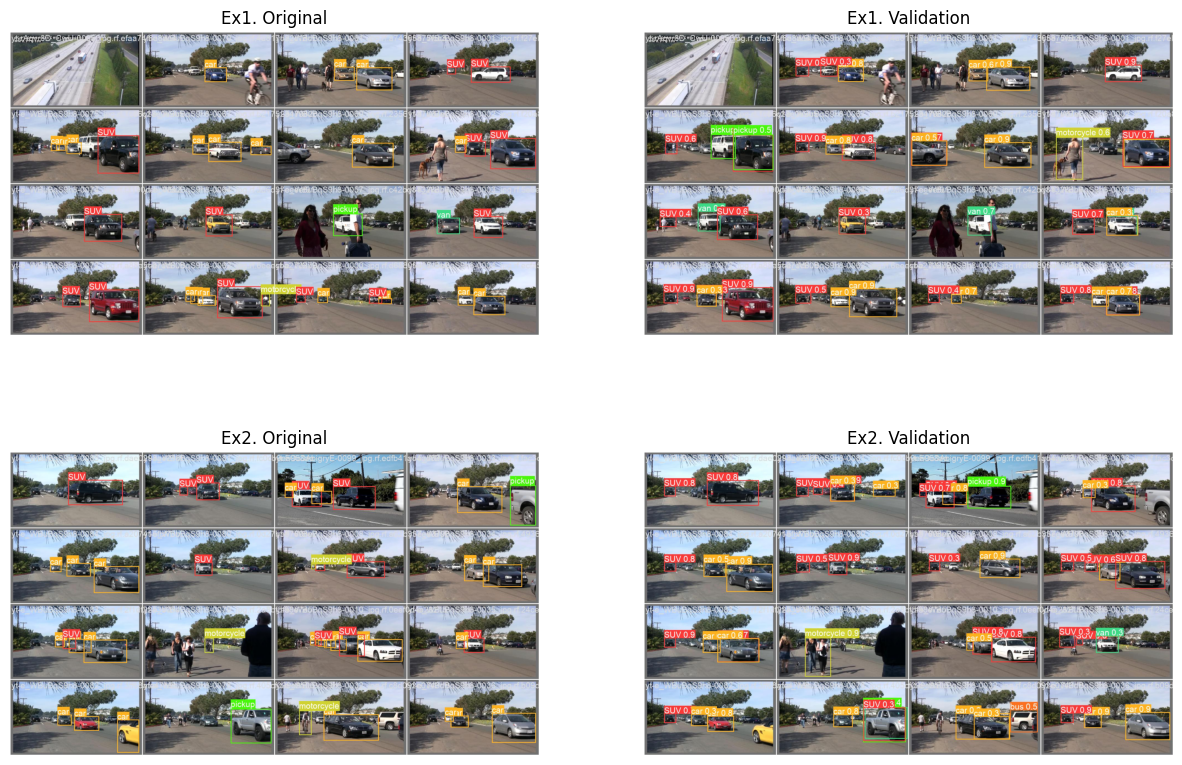

In [63]:
# Examples of the validation

original1 = cv2.imread("./runs/detect/approachA/val_batch0_labels.jpg")
valid1 = cv2.imread("./runs/detect/approachA/val_batch0_pred.jpg")
original2 = cv2.imread("./runs/detect/approachA/val_batch1_labels.jpg")
valid2 = cv2.imread("./runs/detect/approachA/val_batch1_pred.jpg")

plt.figure(figsize=(15, 10))

plt.subplot(2,2,1), plt.imshow(cv2.cvtColor(original1, cv2.COLOR_BGR2RGB)), plt.title('Ex1. Original'), plt.axis('off')
plt.subplot(2,2,2), plt.imshow(cv2.cvtColor(valid1, cv2.COLOR_BGR2RGB)), plt.title('Ex1. Validation'), plt.axis('off')
plt.subplot(2,2,3), plt.imshow(cv2.cvtColor(original2, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray), plt.title('Ex2. Original'), plt.axis('off')
plt.subplot(2,2,4), plt.imshow(cv2.cvtColor(valid2, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray), plt.title('Ex2. Validation'), plt.axis('off')

**A3. Counting in images**


0: 640x640 8 cars, 1: 640x640 1 car, 2: 640x640 1 SUV, 1 bus, 1 pickup, 19.3ms
Speed: 3.2ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


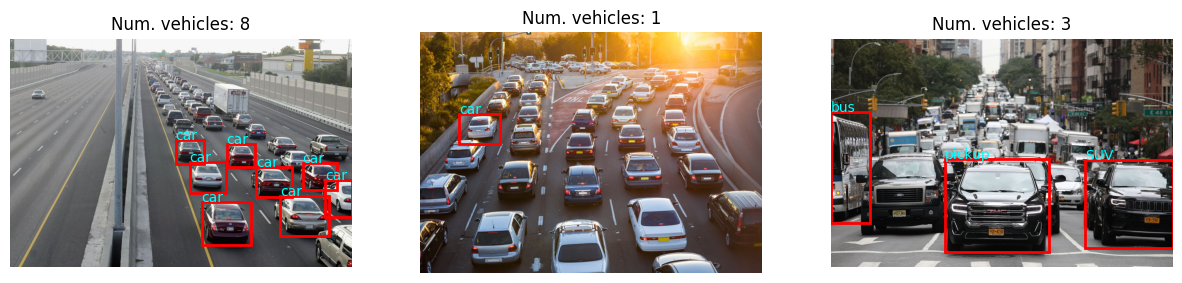

In [17]:
images_path = ["./images/traffic_example.jpg", "./images/traffic_1.jpg", "./images/suv-traffic.jpg"]
model_tester_image(best_A, images_path, labels_A)

**A4. Counting in videos**

In [51]:
videoA_unidirectional = video_taggging_unidirectional("cars_1_test.mp4", best_A, labels_A, keys_A, "A_uni")
videoA_bidirectional = video_taggging_bidirectional("cars_1_test.mp4", best_A, labels_A, keys_A, "A_uni")

./videos/cars_1_test_A_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [52]:
show_results_uni(videoA_unidirectional, labels_A)

Unidirectional test 

Total number of vehicles detected: 12 

Number of SUV: 2
Number of big truck: 0
Number of bus: 4
Number of car: 6
Number of motorcycle: 0
Number of pickup: 0
Number of truck: 0
Number of van: 0


In [53]:
show_results_bi(videoA_bidirectional, labels_A)

Bidirectional test 

Total number of vehicles incoming detected: 9 

Number of SUV: 2
Number of big truck: 0
Number of bus: 3
Number of car: 4
Number of motorcycle: 0
Number of pickup: 0
Number of truck: 0
Number of van: 0


Total number of vehicles outcoming detected: 10 

Number of SUV: 0
Number of big truck: 0
Number of bus: 3
Number of car: 7
Number of motorcycle: 0
Number of pickup: 0
Number of truck: 0
Number of van: 0




#### Approach C

For this approach, we decided to use **Yolov8n.pt** model which was pretrained with COCO dataset.

**C1. Counting in images**


0: 640x640 21 cars, 1 bus, 1 truck, 1: 640x640 41 cars, 2: 640x640 10 cars, 5 buss, 4 trucks, 5 traffic lights, 180.0ms
Speed: 3.6ms preprocess, 60.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


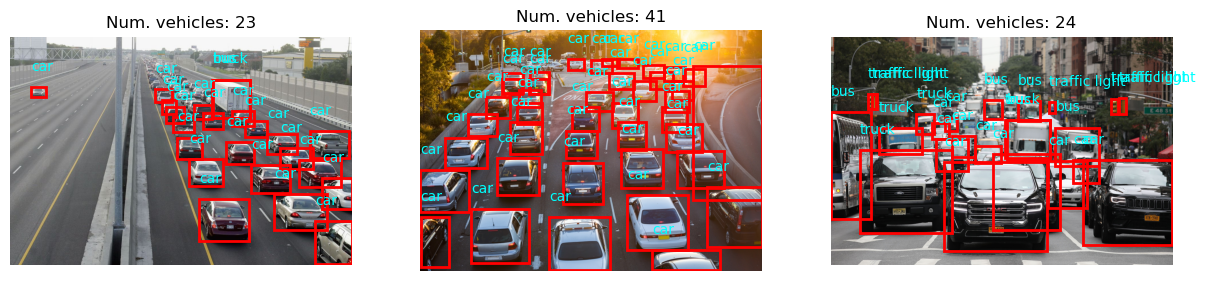

In [17]:
images_path = ["./images/traffic_example.jpg", "./images/traffic_1.jpg", "./images/suv-traffic.jpg"]
labels_coco = open("coco.txt", 'r') 
labels_C = []
for label in labels_coco:
    labels_C.append(label)
model_tester_image("yolov8n.pt", images_path, labels_C)

**C2. Counting in video**

In [24]:
keys_C = [2,3,5,7]
labels_C = ["car", "motorcycle", "bus", "truck"]
videoC_unidirectional = video_taggging_unidirectional("cars_1_test.mp4", "yolov8n.pt", labels_C, keys_C, "C_uni")
videoC_bidirectional = video_taggging_bidirectional("cars_1_test.mp4", "yolov8n.pt", labels_C, keys_C, "C_bi")

./videos/cars_1_test_C_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [25]:
show_results_uni(videoC_unidirectional, labels_C)

Unidirectional test 

Total number of vehicles detected: 37 

Number of car: 33
Number of motorcycle: 0
Number of bus: 0
Number of truck: 4


In [26]:
show_results_bi(videoC_bidirectional, labels_C)

Bidirectional test 

Total number of vehicles incoming detected: 26 

Number of car: 22
Number of motorcycle: 0
Number of bus: 1
Number of truck: 3


Total number of vehicles outcoming detected: 7 

Number of car: 7
Number of motorcycle: 0
Number of bus: 0
Number of truck: 0




### Section 3: Results

After several trainings, we have decided that **Yolov8** is the model which provide the best results. Now, it is time to prove the model in new and different videos. 

#### **Video 1: Heavy traffic**

In [27]:
video_heavy_unidirectional = video_taggging_unidirectional("cars_2_test.mp4", "yolov8n.pt", labels_C, keys_C, "heavy_uni")
video_heavy_bidirectional = video_taggging_bidirectional("cars_2_test.mp4", "yolov8n.pt", labels_C, keys_C, "heavy_bi")

./videos/cars_2_test_heavy_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [28]:
show_results_uni(video_heavy_unidirectional, labels_C)

Unidirectional test 

Total number of vehicles detected: 166 

Number of car: 165
Number of motorcycle: 0
Number of bus: 0
Number of truck: 1


In [29]:
show_results_bi(video_heavy_bidirectional, labels_C)

Bidirectional test 

Total number of vehicles incoming detected: 24 

Number of car: 24
Number of motorcycle: 0
Number of bus: 0
Number of truck: 0


Total number of vehicles outcoming detected: 115 

Number of car: 114
Number of motorcycle: 0
Number of bus: 0
Number of truck: 1




#### **Video 2: Fast traffic**

In [30]:
video_fast_unidirectional = video_taggging_unidirectional("cars_3_test.mp4", "yolov8n.pt", labels_C, keys_C, "fast_uni")
video_fast_bidirectional = video_taggging_bidirectional("cars_3_test.mp4", "yolov8n.pt", labels_C, keys_C, "fast_bi")

./videos/cars_3_test_fast_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [31]:
show_results_uni(video_fast_unidirectional, labels_C)

Unidirectional test 

Total number of vehicles detected: 252 

Number of car: 234
Number of motorcycle: 0
Number of bus: 0
Number of truck: 18


In [32]:
show_results_bi(video_fast_bidirectional, labels_C)

Bidirectional test 

Total number of vehicles incoming detected: 86 

Number of car: 80
Number of motorcycle: 0
Number of bus: 0
Number of truck: 6


Total number of vehicles outcoming detected: 70 

Number of car: 64
Number of motorcycle: 0
Number of bus: 0
Number of truck: 6




#### **Video 3: Mixed and heavy traffic**

In [33]:
video_mixed_unidirectional = video_taggging_unidirectional("cars_4_test.mp4", "yolov8n.pt", labels_C, keys_C, "mixed_uni")
video_mixed_bidirectional = video_taggging_bidirectional("cars_4_test.mp4", "yolov8n.pt", labels_C, keys_C, "mixed_bi")

./videos/cars_4_test_mixed_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [34]:
show_results_uni(video_mixed_unidirectional, labels_C)

Unidirectional test 

Total number of vehicles detected: 109 

Number of car: 82
Number of motorcycle: 7
Number of bus: 3
Number of truck: 17


In [35]:
show_results_bi(video_mixed_bidirectional, labels_C)

Bidirectional test 

Total number of vehicles incoming detected: 39 

Number of car: 31
Number of motorcycle: 0
Number of bus: 1
Number of truck: 7


Total number of vehicles outcoming detected: 44 

Number of car: 32
Number of motorcycle: 3
Number of bus: 2
Number of truck: 7




#### **Video 4: Aerial view traffic**

In [36]:
video_aerial_unidirectional = video_taggging_unidirectional("cars_5_test.mp4", "yolov8n.pt", labels_C, keys_C, "aerial_uni")
video_aerial_bidirectional = video_taggging_bidirectional("cars_5_test.mp4", "yolov8n.pt", labels_C, keys_C, "aerial_bi")

./videos/cars_5_test_aerial_uni.mp4


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [37]:
show_results_uni(video_aerial_unidirectional, labels_C)

Unidirectional test 

Total number of vehicles detected: 0 

Number of car: 0
Number of motorcycle: 0
Number of bus: 0
Number of truck: 0


In [38]:
show_results_bi(video_aerial_bidirectional, labels_C)

Bidirectional test 

Total number of vehicles incoming detected: 0 

Number of car: 0
Number of motorcycle: 0
Number of bus: 0
Number of truck: 0


Total number of vehicles outcoming detected: 0 

Number of car: 0
Number of motorcycle: 0
Number of bus: 0
Number of truck: 0


